
# Energy Efficiency in Buildings — EDA & Preprocessing (No Outlier Removal)

This notebook adds a clean, English-documented workflow to **explore** and **preprocess** the Energy Efficiency dataset.
**Important:** As requested, **no outlier detection/removal** steps are performed.

**Sections**
1. Data Loading & Overview  
2. Data Cleaning (types, missing values, duplicates)  
3. Exploratory Data Analysis (descriptive stats + matplotlib visuals)  
4. Feature Typing & Encoding (numeric vs categorical)  
5. Scaling (standardization)  
6. Dimensionality Reduction (PCA)  
7. Save preprocessed dataset



## 1) Data Loading & Overview

Below we inspect shapes, dtypes, and a quick peek at the data.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Make plots a bit larger
plt.rcParams['figure.figsize'] = (7, 5)

DATA_PATH = r"../data/processed/energy_efficiency_clean_fill.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [2]:
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

Shape: (707, 10)

Dtypes:
X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object

Missing values per column:
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


In [3]:
df = df.astype({'X6': 'category', 'X8': 'category'})

## 2) Data Cleaning
 
- Drop exact duplicate rows.

In [4]:
# Drop duplicates
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate rows.")

print("\nDtypes after cleaning:")
print(df.dtypes)

Dropped 10 duplicate rows.

Dtypes after cleaning:
X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6    category
X7     float64
X8    category
Y1     float64
Y2     float64
dtype: object



## 3) Exploratory Data Analysis (EDA)

We compute descriptive statistics and visualize distributions and relationships.
Targets are typically `Heating_Load` (Y1) and `Cooling_Load` (Y2). If your column names differ, adjust in the cell below.


In [5]:
print("Descriptive statistics (numerical columns):\n")
display(df.describe().T)

Descriptive statistics (numerical columns):



,count,mean,std,min,25%,50%,75%,max
X1,697.0,0.764519,0.104640,0.62,0.69,0.76,0.86,0.98
X2,697.0,670.990674,87.074443,514.50,588.00,686.00,735.00,808.50
X3,697.0,318.500000,43.419672,245.00,294.00,318.50,343.00,416.50
X4,697.0,177.160689,45.312074,110.25,147.00,220.50,220.50,295.00
X5,697.0,5.302726,1.750462,3.50,3.50,7.00,7.00,7.00
X7,697.0,0.236514,0.132874,0.00,0.10,0.25,0.40,0.40
Y1,697.0,22.371673,10.129897,6.01,13.00,19.27,31.89,42.96
Y2,697.0,24.718680,9.537355,10.90,15.66,23.11,33.16,48.03


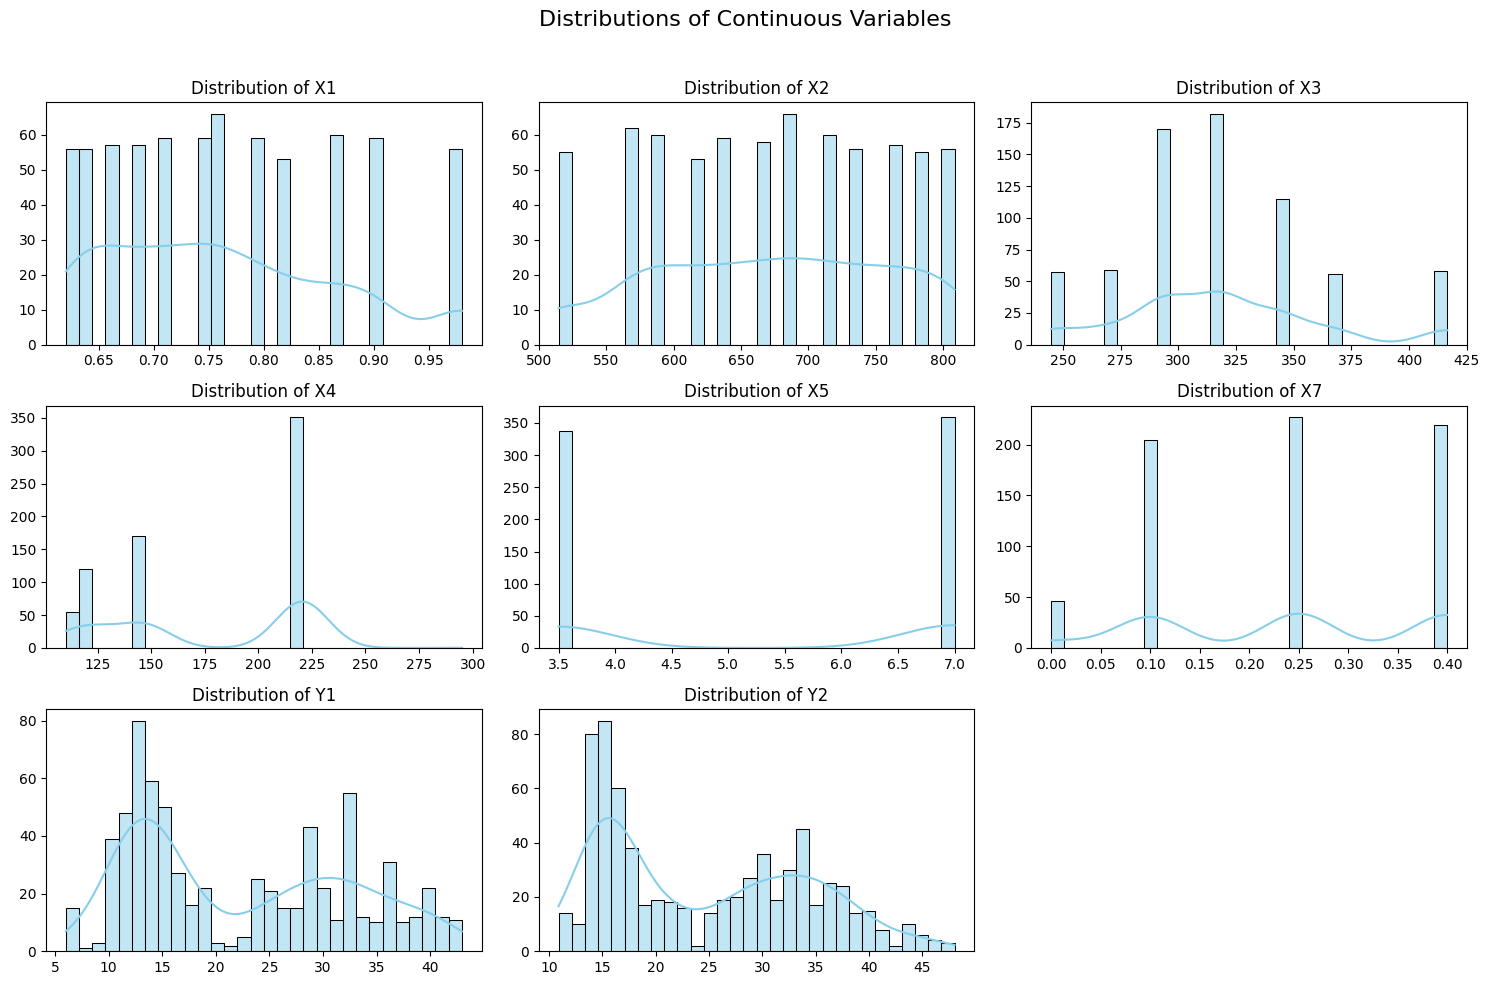

In [6]:
continuous_cols = ['X1','X2','X3','X4','X5','X7','Y1','Y2']

n_cols = 3
n_rows = (len(continuous_cols) + n_cols - 1) // n_cols  # automatic row count

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()  # flatten grid for easy iteration

for i, col in enumerate(continuous_cols):
    sns.histplot(data=df, x=col, bins=30, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distributions of Continuous Variables", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

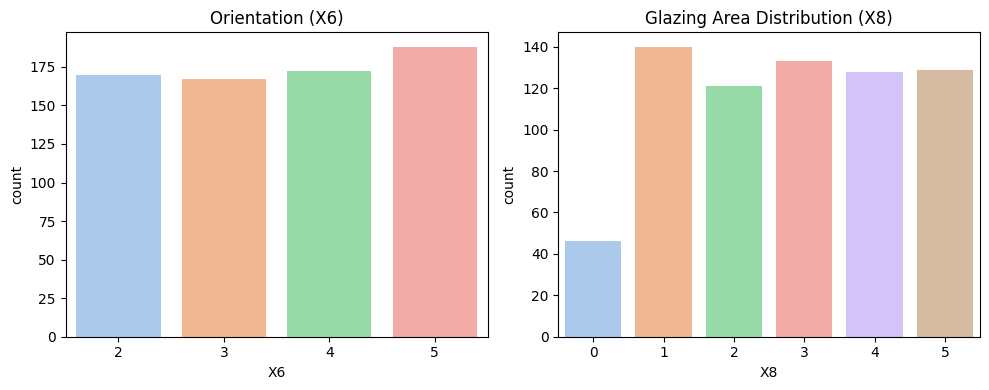

In [7]:
# * Countplots After Cleaning Categorical Variables
fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x='X6', hue='X6', data=df, palette='pastel', legend=False, ax=axes[0])
sns.countplot(x='X8', hue='X8', data=df, palette='pastel', legend=False, ax=axes[1])

axes[0].set_title('Orientation (X6)')
axes[1].set_title('Glazing Area Distribution (X8)')
plt.tight_layout()
plt.show()

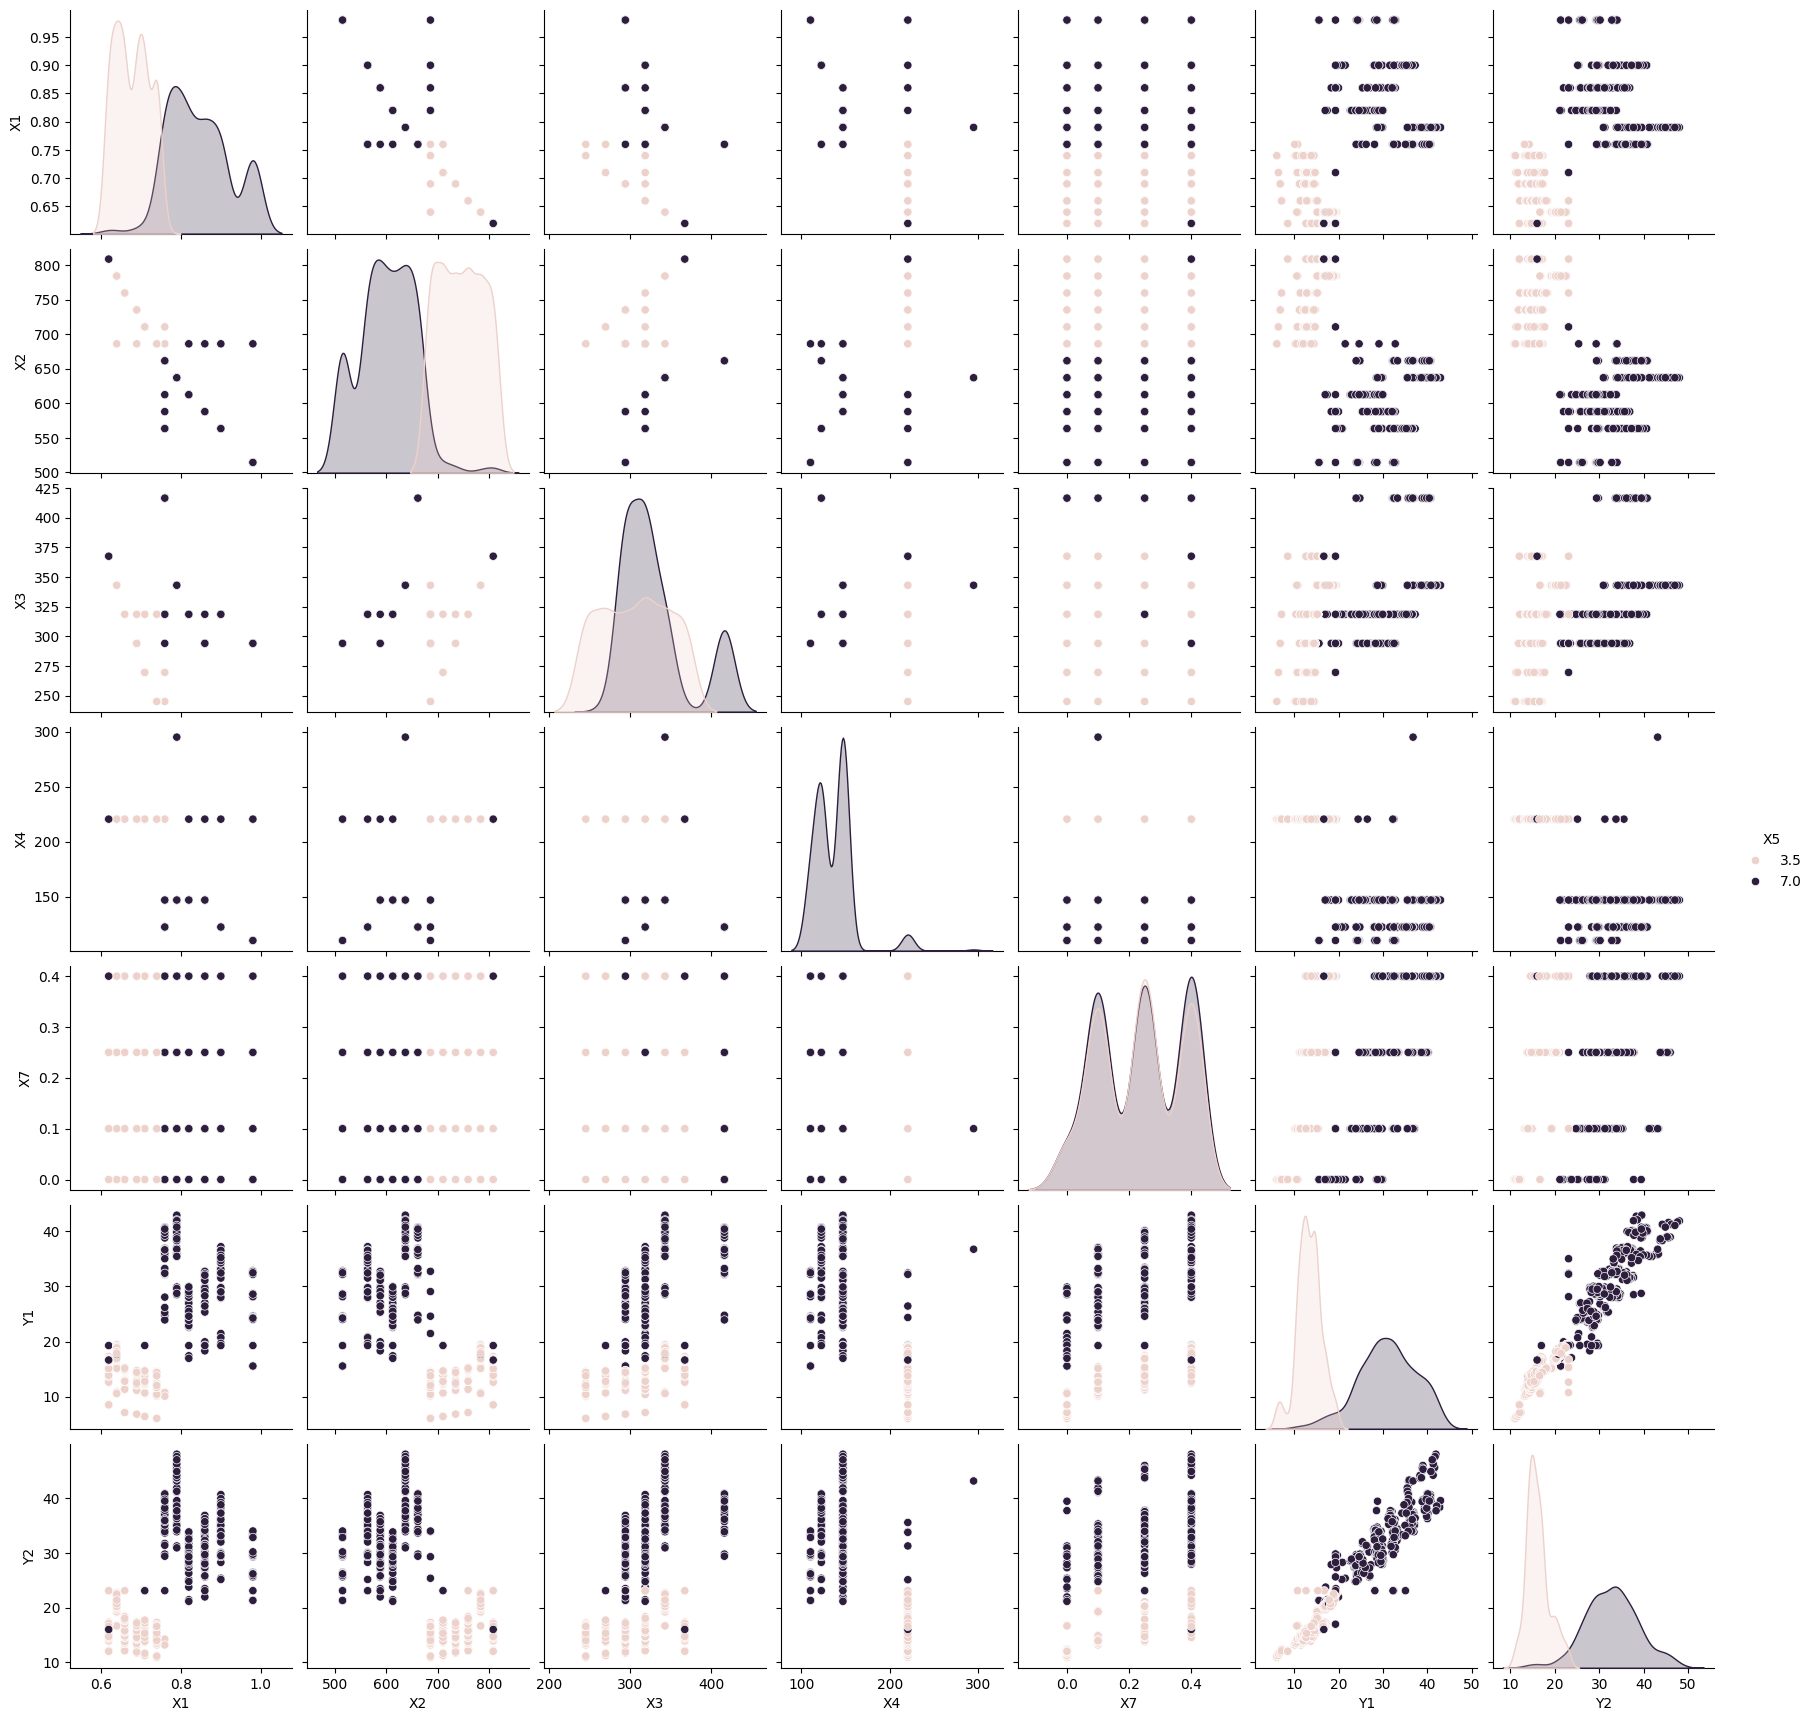

In [8]:
sns.pairplot(df[['X1','X2','X3','X4','X5','X7','Y1','Y2']], hue='X5')

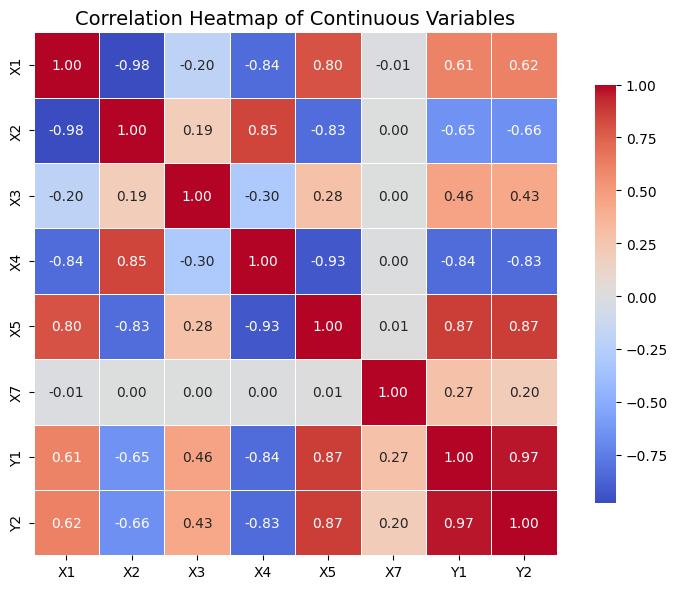

In [9]:
# * Correlation Heatmap
numeric_cols = ['X1','X2','X3','X4','X5','X7','Y1','Y2']

corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title("Correlation Heatmap of Continuous Variables", fontsize=14)
plt.tight_layout()
plt.show()

Drop high correlated columns

In [10]:
df_original = df.copy()
df = df.drop(columns = ['X2', 'X4'])


## 4) Feature Typing & Encoding

We split columns into **numeric** and **categorical**. For categorical columns we apply **One-Hot Encoding**.  
Note: Orientation / Glazing distribution (e.g., `X6`, `X8`) are typically categorical even if coded as integers.


In [11]:
# Identify numeric vs categorical
numeric_cols = [c for c in df.columns if (df[c].dtype.kind in "if") and (c not in ['Y1', 'Y2'])]
categorical_cols = [c for c in df.columns if c not in numeric_cols+['Y1', 'Y2']]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# One-Hot Encode categoricals (if any)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded[['Y1', 'Y2']] = df[['Y1', 'Y2']].copy()

print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Numeric columns: ['X1', 'X3', 'X5', 'X7']
Categorical columns: ['X6', 'X8']
Encoded shape: (697, 14)


,X1,X3,X5,X7,Y1,Y2,X6_3,X6_4,X6_5,X8_1,X8_2,X8_3,X8_4,X8_5
0,0.98,294.0,7.0,0.0,15.55,21.33,False,False,False,False,False,False,False,False
1,0.98,294.0,7.0,0.0,15.55,21.33,True,False,False,False,False,False,False,False
2,0.98,294.0,7.0,0.0,15.55,21.33,False,True,False,False,False,False,False,False
3,0.98,294.0,7.0,0.0,15.55,21.33,False,False,True,False,False,False,False,False
4,0.90,318.5,7.0,0.0,20.84,28.28,False,False,False,False,False,False,False,False



## 5) Scaling (Normalization)

We standardize numerical features to have mean 0 and std 1. This is important for PCA and many ML models.


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = df_encoded.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

df_normalized.head()

,X1,X3,X5,X7,Y1,Y2,X6_3,X6_4,X6_5,X8_1,X8_2,X8_3,X8_4,X8_5
0,1.000000,0.285714,1.0,0.0,15.55,21.33,False,False,False,False,False,False,False,False
1,1.000000,0.285714,1.0,0.0,15.55,21.33,True,False,False,False,False,False,False,False
2,1.000000,0.285714,1.0,0.0,15.55,21.33,False,True,False,False,False,False,False,False
3,1.000000,0.285714,1.0,0.0,15.55,21.33,False,False,True,False,False,False,False,False
4,0.777778,0.428571,1.0,0.0,20.84,28.28,False,False,False,False,False,False,False,False



## 6) Dimensionality Reduction (PCA)

We project the (scaled) feature space onto 2 principal components to visualize structure.  
This is **exploratory only** and **does not** remove outliers.


Explained variance ratio (2 PCs): [0.61448708 0.21680814]


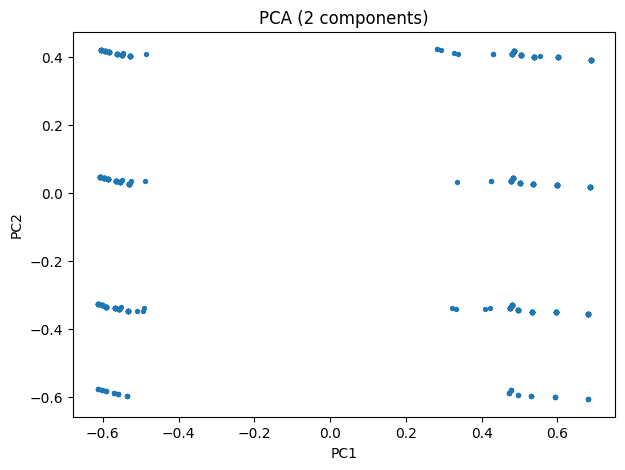

In [13]:
X = df_normalized[[c for c in df_normalized.columns if c not in ['Y1', 'Y2']]]
X = X.select_dtypes(include=[np.number])
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (2 PCs):", pca.explained_variance_ratio_)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=8)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA (2 components)")
plt.show()


## 7) Save Preprocessed Dataset

We save the encoded and scaled dataset so it can be used directly for modeling.


In [ ]:
out_path = r"../data/processed/energy_efficiency_prepared.csv"
df_normalized.to_csv(out_path, index=False)
print("Saved preprocessed dataset to:", out_path)

Saved preprocessed dataset to: energy_efficiency_ready_for_model.csv
